In [ ]:
#importation des bibliothèques
import cv2
import os
%tensorflow_version 1.x
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
from sklearn.model_selection import train_test_split
%tensorflow_version 1.x
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plot
#import cv2
import sys
from google.colab.patches import cv2_imshow

In [ ]:
#importation de google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#définition des variables
nbr_classes=2
width=160
height=120

taille_batch=50
nbr_entrainement=100
learning_rate=1E-3
nbr_mask=2
momentum = 0.99

kernel_size = 3
kernel_size_deconv = 2
kernel_size_f = 1
nbr_kernel12 = 16
nbr_kernel34 = 32
nbr_kernel56 = 64
nbr_kernel78 = 128
stride =2
stridec = [1,1,1,1]

In [ ]:
#définition des fonctions
def normalisation(couche_prec):
    mean, var=tf.nn.moments(couche_prec, [0])
    scale=tf.Variable(tf.ones(shape=(np.shape(couche_prec)[-1])))
    beta=tf.Variable(tf.zeros(shape=(np.shape(couche_prec)[-1])))
    result=tf.nn.batch_normalization(couche_prec, mean, var, beta, scale, 0.001)
    return result

def convolution(input, taille_noyau, nbr_conv, stride, training=False):
  #nouvelle couche
  # Création des pondérations en les initialisant selon une loi normale
  w=tf.Variable(tf.random.truncated_normal(shape=(taille_noyau, taille_noyau, int(input.shape[-1]), nbr_conv)))
  # Création des biais en les initialisant à 0
  b=np.zeros(nbr_conv)
  # Définition de l'opération de convolution sur la couche_prec
  result_conv=tf.nn.conv2d(input, w, strides=stride, padding='SAME')
  # Ajout du biais
  result=result_conv+b
  result=tf.layers.batch_normalization(result, training=training, momentum=momentum)
  return result
  
def deconvolution(input, taille_noyau, nbr_conv, stride, training=False):
    w=tf.Variable(tf.random.truncated_normal(shape=(taille_noyau, taille_noyau, nbr_conv, int(input.get_shape()[-1]))))
    b=np.zeros(nbr_conv)
    out_h=int(input.get_shape()[1])*stride
    out_w=int(input.get_shape()[2])*stride
    b_size=tf.shape(input)[0]
    result=tf.nn.conv2d_transpose(input, w, output_shape=[b_size, out_h, out_w, nbr_conv], strides=[1, stride, stride, 1], padding='SAME')
    result=result+ b
    result=tf.layers.batch_normalization(result, training=training)
    return result



code de redimensionnement du dataset lyft-udacity-challenge

In [ ]:
from PIL import Image
datapath = ['/dataA', '/dataB']
camerapath = ['/CameraRGB', '/CameraSeg']
pathCh ='/content/drive/My Drive/dataset/lyft-udacity-challenge/'

def resizing120_160(path_img, name, pathGroup, pathCamera):
  baseheight = 120
  img = Image.open(path_img)
  imgR = img.resize((160, 120), Image.ANTIALIAS)
  imgR.save(pathCh+'resized'+pathGroup+pathCamera+'/'+name)
  img.close()

for path1 in datapath:
  for path2 in camerapath:
    for filename in os.listdir(pathCh+path1+path2):
      resizing120_160(pathCh+path1+path2+'/'+filename, filename+'.png',path1, path2)





In [ ]:


ph_images=tf.placeholder(shape=(None, height, width, 3), dtype=tf.float32, name='images')
ph_masks=tf.placeholder(shape=(None,  height, width, nbr_classes), dtype=tf.float32)
ph_is_training=tf.placeholder_with_default(True, (), name='is_training')
#  160 x 120 x 3
#1ere couche - convo
 
result=convolution(ph_images, kernel_size, nbr_kernel12, stridec) # conv3*3  160 x 120 x 16

result=tf.nn.relu(result)

def couche_c(result, nbr_kernel, kKernel_size):
  result=convolution(result, kKernel_size, nbr_kernel, stridec, training=ph_is_training)
  result=tf.nn.relu(result)
  return result

#2eme couche - convo + pooling

result = couche_c(result, nbr_kernel12, kernel_size) # conv3*3  160 x 120 x 16
r1 = result
result=tf.nn.max_pool(result, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME') # pool2*2  80 x 60 x 16

#3eme couche - convo

result = couche_c(result, nbr_kernel34, kernel_size)# conv3*3  80 x 60 x 32

#4eme couche - convo + pooling
result = couche_c(result, nbr_kernel34, kernel_size)# conv3*3  80 x 60 x 32
r2 = result
result=tf.nn.max_pool(value=result, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')# pool2*2  40 x 30 x 32

#5eme couche - convo
result = couche_c(result, nbr_kernel56, kernel_size)# conv3*3  40 x 30 x 64

#6eme couche - convo + pooling
result = couche_c(result, nbr_kernel56, kernel_size)# conv3*3  40 x 30 x 64
r3 = result
result=tf.nn.max_pool(value=result, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')# pool2*2  20 x 15 x 64

#7eme couche - convo
result = couche_c(result, nbr_kernel78, kernel_size)# conv3*3  20 x 15 x 128

#8eme couche - convo
result = couche_c(result, nbr_kernel78, kernel_size)# conv3*3  20 x 15 x 128

#Phase de deconv
#1
result = deconvolution(result, kernel_size_deconv, nbr_kernel56, stride, training=False)# upconv2*2 40 x 30 x 64
result=tf.nn.relu(result)
result = tf.concat((result, r3), axis=3)# concat  40 x 30x 128

#2 - conv
result = couche_c(result, nbr_kernel56, kernel_size)# conv3*3  40 x 30x 64
#3 - conv + up-conv
result = couche_c(result, nbr_kernel56, kernel_size)# conv3*3  40 x 30x 64
result = deconvolution(result, kernel_size_deconv, nbr_kernel34, stride, training=False)# upconv2*2  80 x 60x 32
result=tf.nn.relu(result)
result = tf.concat((result, r2), axis=3)# concat  80 x 60x 64

#4 - conv
result = couche_c(result, nbr_kernel34, kernel_size)# conv3*3  80 x 60x 32

#5 - conv + up-conv
result = couche_c(result, nbr_kernel34, kernel_size)# conv3*3  80 x 60x 32
result = deconvolution(result, kernel_size, nbr_kernel12, stride, training=False)# upconv2*2  160 x 120x 16
result = tf.concat((result, r1), axis=3)# upconv2*2  160 x 120x 32

#6 - conv
result = couche_c(result, nbr_kernel12, kernel_size)# conv3*3  160 x 120x 16

#7 - conv
result = couche_c(result, nbr_kernel12, kernel_size)# conv3*3  160 x 120x 16


#conv finale 1*1
result = convolution(result, kernel_size_f, 2, stridec )# conv1*1  160 x 120x 2

scso=tf.nn.sigmoid(result, name="sortie")



loss=tf.nn.sigmoid_cross_entropy_with_logits(labels=ph_masks, logits=result)


accuracy=tf.reduce_mean(tf.cast(tf.equal(tf.round(scso), ph_masks), tf.float32))



extra_update_ops=tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
  train=tf.train.AdamOptimizer(learning_rate).minimize(loss)
 
# DATA CONDITIONING

dir_img="CameraRGB/"
dir_mask="CameraSeg/"


tab_img = []
tab_mask = []
# Dans ce dossier, les images sont de résolution 120 x 160
for dir in ['/content/drive/My Drive/dataset/lyft-udacity-challenge/resized/dataA/']:
  i=0
  for file in os.listdir(dir+dir_img):
    i=i+1
  
   
    tab_img.append(cv2.imread(dir+dir_img+file)/255)
  
    img_mask=cv2.imread(dir+dir_mask+file)[:,:,2]
    img_mask_result=np.zeros(shape=(height, width, 2), dtype=np.float32)

    
    # Pour deux classes de pixels (ici les classes 7 et 9)
    img_mask_result[:,:,0][img_mask==7]=1.
    img_mask_result[:,:,1][img_mask==9]=1.
    
    # Pour ajouter deux classes de pixels supplémentaires (ici les classes 1 et 10) 
    #il faut décommenter ces deux lignes

    # img_mask_result[:,:,2][img_mask==1]=1.
    # img_mask_result[:,:,3][img_mask==10]=1.
    
    # Vous pouvez choisir les objets à segmenter qui vous interessent parmis
    # les labels spécifiés dans le tableau qui suit tout le script
    
    tab_mask.append(img_mask_result)
    if i==500:
      break
# Création des tableaux d'images et de masks
tab_img=np.array(tab_img)
tab_mask=np.array(tab_mask)

# Ces tableaux sont splités en un set training et un set testing
train_images, test_images, train_labels, test_labels=train_test_split(tab_img, tab_mask, test_size=.1)

# Instanciation de la classe sauvegarde
saver=tf.train.Saver()

with tf.Session() as s:
  s.run(tf.global_variables_initializer())
  tab_train=[]
  tab_test=[]
  for id_entrainement in np.arange(nbr_entrainement):
      print("> Entrainement", id_entrainement)
      for batch in np.arange(0, len(train_images), taille_batch):
          s.run(train, feed_dict={
              ph_images: train_images[batch:batch+taille_batch],
              ph_masks: train_labels[batch:batch+taille_batch],
              ph_is_training: True
          })
      print("  entrainement OK")
      tab_accuracy_train=[]
      for batch in np.arange(0, len(train_images), taille_batch):
          p=s.run(accuracy, feed_dict={
              ph_images: train_images[batch:batch+taille_batch],
              ph_masks: train_labels[batch:batch+taille_batch]
          })
          tab_accuracy_train.append(p)
      print("  train:", np.mean(tab_accuracy_train))
      tab_accuracy_test=[]
      for batch in np.arange(0, len(test_images), taille_batch):
          p=s.run(accuracy, feed_dict={
              ph_images: test_images[batch:batch+taille_batch],
              ph_masks: test_labels[batch:batch+taille_batch]
          })
          tab_accuracy_test.append(p)
      print("  test :", np.mean(tab_accuracy_test))
      tab_train.append(1-np.mean(tab_accuracy_train))
      tab_test.append(1-np.mean(tab_accuracy_test))
  
 # [FAIRE APPARAITRE LES DEUX COURBES DE PERFORMANCE]

  
  saver.save(s, './mon_modele/modele')
plot.ylim(0, 1)
plot.grid()
plot.plot(tab_train, label="Train error")
plot.plot(tab_test, label="Test error")
plot.legend(loc="upper right")
plot.show()

Courbes de performance

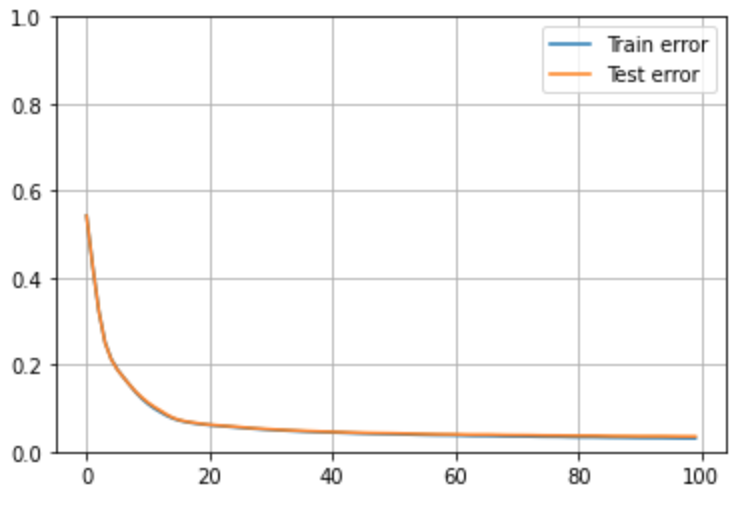

A partir de la courbe d'erreur on peut dire que ce modèle est fiable pour segmenter les images 

fonction pour éclaircir l'image segmentée

In [ ]:
def eclaircissement(image):
  for i in range (120):
    for j in range(160):
      if (image[i][j][0]==0 and image[i][j][1]==0 and image[i][j][2]==0):
        image[i][j][0]=1
        image[i][j][1]=1
        image[i][j][2]=1
  return image





exécution du modèle sauvegardé

In [ ]:
import cv2
import numpy as np
from PIL import Image as im
from google.colab.patches import cv2_imshow

is_training= True
#cap=cv2.VideoCapture(0)
np.set_printoptions(formatter={'float': '{:0.3f}'.format})
with tf.Session() as s:
    saver=tf.train.import_meta_graph('/content/mon_modele/modele.meta')
    saver.restore(s, tf.train.latest_checkpoint('/content/mon_modele'))
    graph=tf.get_default_graph()
    images=graph.get_tensor_by_name("images:0")
    sortie=graph.get_tensor_by_name("sortie:0")
    is_training=graph.get_tensor_by_name("is_training:0")
    #while True:
    frame=cv2.imread('/content/drive/MyDrive/dataset/lyft-udacity-challenge/resized/dataB/CameraRGB/F2-3.png.png')
    map=cv2.imread('/content/drive/MyDrive/dataset/lyft-udacity-challenge/resized/dataB/CameraSeg/02_00_093.png.png')
    cv2_imshow(cv2.resize(frame, (160, 120)))
    cv2_imshow(cv2.resize(map, (160, 120)))
    frame = cv2.resize(frame, (160,120))
    prediction=s.run(sortie, feed_dict={images:[frame], is_training: False})
    #prediction=s.run(sortie, feed_dict={images: [test.reshape(28, 28, 1)]})
    f = prediction[0]
    z = np.zeros((120, 160, 3))
    z[:,:,1:] = f
    z=eclaircissement(z)
    z=z*255
    print(np.shape(f))
    print(np.shape(z))
    print(np.shape(prediction))
    cv2_imshow(z)
    print(tf.shape(prediction))
    print(prediction)
    #if cv2.waitKey(20)&0xFF==ord('q'):
    #    break
#cap.release()
#cv2.destroyAllWindows()

image test

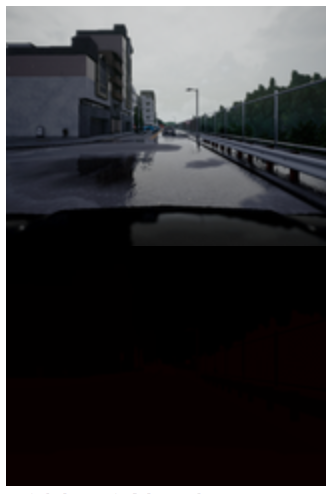

image segmentée

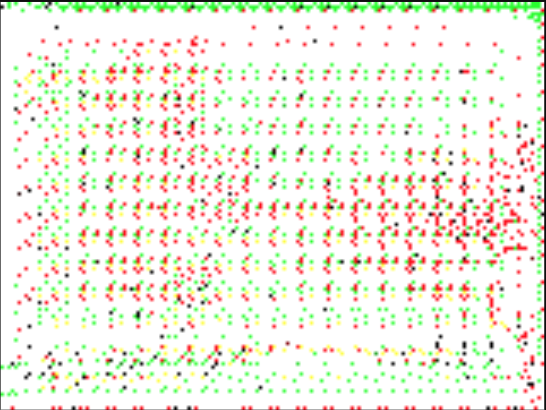

le résultat de segmentation de cette image nous permet d'identifier un peu la route mais pour la végétation on n'a pas obtenu un bon résultat. 